PDE: $$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}$$
BC and IC:  $$u=\sin(\pi x) \cdot e^{-y} \cdot e^{-t}$$

In [ ]:
! pip install deepxde
import deepxde as dde
import numpy as np
geom= dde.geometry.Interval(-1,1)
timedomain=dde.geometry.TimeDomain(0,1)
geomtime=dde.geometry.GeometryXTime(geom,timedomain)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.8 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


## Defining PDE equation

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return dy_t - 0.5 * dy_xx

## Boundary Condition And Initial Condition

In [ ]:
def func(x):
     return np.sin(np.pi*x[:,0:1])*np.exp(-x[:,1:])

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)


## Training Data


In [ ]:
data= dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution = func,
    num_test =1000,
)


# Initializer And Optimizer

In [ ]:
initializer = "Glorot uniform"
Optimizer = "adam"

## Neural Network Structure

In [ ]:
layer_size =[2]+[32]*4+[1]
activation = "tanh"
net = dde.maps.FNN(layer_size,activation,initializer)


## Compile The Model And Train

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.086746 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.662640 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.66e-02, 3.72e-02, 3.89e-01]    [3.83e-02, 3.72e-02, 3.89e-01]    []  
1000      [7.72e-04, 4.98e-04, 2.33e-04]    [8.22e-04, 4.98e-04, 2.33e-04]    []  
2000      [1.99e-04, 1.51e-04, 6.61e-05]    [1.89e-04, 1.51e-04, 6.61e-05]    []  
3000      [1.31e-04, 7.15e-05, 4.01e-05]    [1.17e-04, 7.15e-05, 4.01e-05]    []  
4000      [8.03e-05, 4.17e-05, 1.48e-05]    [8.31e-05, 4.17e-05, 1.48e-05]    []  
5000      [5.88e-05, 2.69e-05, 7.19e-06]    [5.52e-05, 2.69e-05, 7.19e-06]    []  
6000      [1.09e-04, 2.94e-05, 8.72e-06]    [8.13e-05, 2.94e-05, 8.72e-06]    []  
7000      [3.72e-04, 1.05e-04, 5.40e-05]    [1.43e-04, 1.05e-04, 5.40e-05]    []  
8000      [2.96e-05, 1.16e-05, 1.91e-06]    [3.30e-05, 1.16e-05, 1.91e-06]    []  
9000      [9.12e-05, 3.13e-05, 2.28e-05]    [5.00e-05, 3.13e-05, 2.28e-05]    []  
10000     [2.12e-05, 8.86e-06, 2.0

### Results From NN

In [ ]:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def heat_eq_exact_solution(x, t):
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():

    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (1, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


In [ ]:

gen_exact_solution()

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


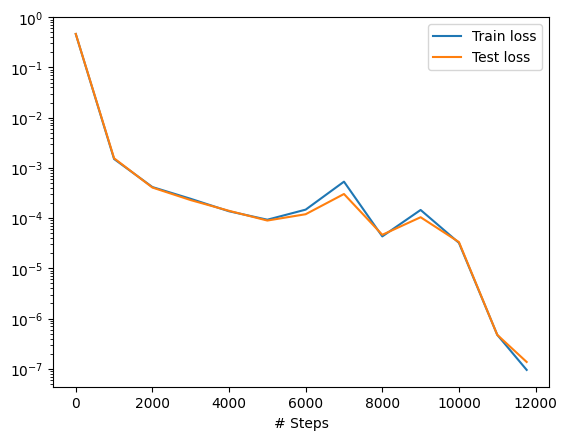

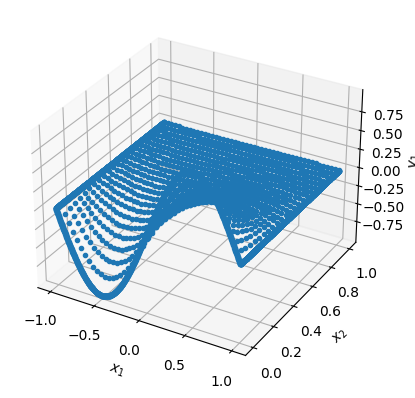

Mean residual: 0.00029776513
L2 relative error: 0.14708336297932578


In [ ]:
def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))